# Restricted Boltzmann Machine Defintion

In [1]:
# TODO g = 1 + ap of g = ap

In [2]:
# Import PyTorch library
import torch
import torch.nn as nn

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [3]:
# https://github.com/khanhnamle1994/MetaRec/blob/b5e36cb579a88b32cdfb728f35f645d76b24ad95/Boltzmann-Machines-Experiments/RBM-CF-PyTorch/rbm.py#L23
# Create the Restricted Boltzmann Machine architecture
class RBM(nn.Module):
    def __init__(self, n_vis, n_hid, k, batch_size):
        """
        Initialize the parameters (weights and biases) we optimize during the training process
        :param n_vis: number of visible units
        :param n_hid: number of hidden units
        """
        self.i = 0
        self.K = k
        self.batch_size = batch_size

        # Weights used for the probability of the visible units given the hidden units
        super().__init__()
        self.W = torch.zeros(k, n_hid, n_vis)  # torch.rand: random normal distribution mean = 0, variance = 1

        # Bias probability of the visible units is activated, given the value of the hidden units (p_v_given_h)
        self.v_bias = torch.zeros(k, 1, n_vis)  # fake dimension for the batch = 1

        # Bias probability of the hidden units is activated, given the value of the visible units (p_h_given_v)
        self.h_bias = torch.zeros(1, n_hid)  # fake dimension for the batch = 1

        if torch.cuda.is_available():
            self.W = self.W.cuda()
            self.v_bias = self.v_bias.cuda()
            self.h_bias = self.h_bias.cuda()
    
    def lr(self):
        return 0.01 / self.batch_size

    def sample_h(self, x):
        """
        Sample the hidden units
        :param x: the dataset
        """

        # Probability h is activated given that the value v is sigmoid(Wx + a)
        # torch.mm make the product of 2 tensors
        # W.t() take the transpose because W is used for the p_v_given_h

        temp = torch.transpose(self.W, 1, 2)

        wxs = []
        for i in range(self.K):
            wxs.append(torch.mm(x[i], temp[i]))
            
        wx = torch.stack(wxs)
        # wx = torch.bmm(x.cpu(), temp.cpu())
        # if torch.cuda.is_available():
            # wx = wx.cuda()
        wx_sum = torch.sum(wx, 0)
        # print(wx.shape)

        # Expand the mini-batch
        activation = wx_sum + self.h_bias.expand_as(wx_sum)
        # print(activation.shape)

        # Calculate the probability p_h_given_v
        p_h_given_v = torch.sigmoid(activation)

        # print("h sparse", p_h_given_v.is_sparse, torch.bernoulli(p_h_given_v).is_sparse)

        # Construct a Bernoulli RBM to predict whether an user loves the movie or not (0 or 1)
        # This corresponds to whether the n_hid is activated or not activated
        return p_h_given_v, torch.bernoulli(p_h_given_v)

    def sample_v(self, y):
        """
        Sample the visible units
        :param y: the dataset
        """
        # print(y.mean(), y.min(), y.max())

        exponents = []
        for k in range(self.K):
            wy = torch.mm(y, self.W[k])
            activation = wy + self.v_bias[k].expand_as(wy)
            exponents.append(torch.exp(activation))

        exponent_tensor = torch.stack(exponents)
        exponent_sum = torch.sum(exponent_tensor, 0)
        probs = []
        for k in range(self.K):
            p_v_k_given_h = exponent_tensor[k] / exponent_sum
            # print(p_v_k_given_h.mean(), p_v_k_given_h.min(), p_v_k_given_h.max())
            probs.append(p_v_k_given_h)

        p_v_given_h = torch.stack(probs)
        # try:
        # print(p_v_given_h.mean(), p_v_given_h.max(), p_v_given_h.min())
        # todo multinomial
        bern = torch.bernoulli(p_v_given_h)
        # if self.i == 0:
        #     print(p_v_given_h[0][0][0])
        #     print(p_v_given_h[0][0].min(), p_v_given_h[0][0].max())
        return p_v_given_h, bern
        # except Exception as e:
            # raise Exception("bernoulli kapot")


    def train_model(self, v0, vk, ph0, phk):
        """
        Perform contrastive divergence algorithm to optimize the weights that minimize the energy
        This maximizes the log-likelihood of the model
        """

        ph0_K = torch.stack([ph0 for _ in range(self.K)])
        phk_K = torch.stack([phk for _ in range(self.K)])

        poss = []
        negs = []
        for i in range(self.K):
            poss.append(torch.mm(torch.transpose(v0, 1, 2)[i], ph0_K[i]))
            negs.append(torch.mm(torch.transpose(vk, 1, 2)[i], phk_K[i]))

        pos = torch.stack(poss)
        neg = torch.stack(negs)

        # pos = torch.bmm(torch.transpose(v0, 1, 2).cpu(), ph0_K.cpu())
        # neg = torch.bmm(torch.transpose(vk, 1, 2).cpu(), phk_K.cpu())
        # if torch.cuda.is_available():
        #     pos = pos.cuda()
        #     neg = neg.cuda()

        w_extra = torch.transpose(pos - neg, 1, 2)
        v_extra = torch.sum((v0 - vk), 1)
        h_extra = torch.sum((ph0 - phk), 0)

        # if self.i % 45 == 0:
            # print(torch.max(w_extra), torch.max(v_extra), torch.max(h_extra), flush=True)

        # Approximate the gradients with the CD algorithm
        # TODO learning rate toevoegen
        self.W += self.lr() * w_extra

        # Add (difference, 0) for the tensor of 2 dimensions
        self.v_bias += self.lr() * v_extra.unsqueeze(1)
        self.h_bias += self.lr() * h_extra
        self.i += 1

In [4]:
cuda = torch.device('cuda')

# General Imports

In [5]:
import numpy as np
import pickle as pickle
import pandas as pd
import scipy
import sklearn
import gzip
import json
from tqdm import tqdm, trange
import os
from collections import Counter
from datetime import datetime
import math
tqdm.pandas() #for progres_apply etc.

# Reading

In [6]:
def load_interactions(path, n_splits=5):
    df = pd.read_pickle(os.path.join(os.getcwd(), path))
    df[['interactions', 'train', 'val', 'test']] = df[['interactions', 'train', 'val', 'test']].applymap(lambda x: np.array(x, dtype=np.int32))
    interactions_dict = {}
    for split in trange(n_splits):
        for column in ['train', 'val', 'test']:
            interactions_dict[split, column] = pd.DataFrame({
                'user_id': df['user_id'],
                'steam_id': df['steam_id'],
                'item_id': df[column].apply(lambda x: x[split, 0]),
                'playtime_forever': df[column].apply(lambda x: x[split, 1]),
                'playtime_2weeks': df[column].apply(lambda x: x[split, 2])})
    return interactions_dict

In [7]:
interactions = load_interactions("./data-cleaned/interactions_splits.pkl.gz")
interactions[0, 'train'].head()

100%|██████████| 5/5 [00:00<00:00,  7.17it/s]


,user_id,steam_id,item_id,playtime_forever,playtime_2weeks
0,76561197981203305,76561197981203305,"[3485, 2370, 163, 2188, 2484, 2130, 3197, 413,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,bosslucek,76561198029968002,"[470, 3223, 1912, 4349, 2249, 380, 3860, 1483,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,76561198067911521,76561198067911521,"[173, 139, 2088, 2132, 285, 352, 678, 521, 798...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,icantwait,76561197971666535,"[206, 299, 354, 1125, 2196, 2839, 1752, 1410, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,kushziller,76561198021307778,"[417, 1897, 4786, 840, 1637, 3957, 926, 505, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
games = pd.read_pickle(os.path.join(os.getcwd(), "./data-cleaned/games.pkl.gz"))
games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore,users_count
0,Valve,[Action],Counter-Strike: Global Offensive,Counter-Strike: Global Offensive,http://store.steampowered.com/app/730/CounterS...,2012-08-21,"[FPS, Multiplayer, Shooter, Action, Team-Based...",NaN,http://steamcommunity.com/app/730/reviews/?bro...,"[Multi-player, Steam Achievements, Full contro...",14.99,False,730,Valve,Very Positive,83,42618
1,Valve,"[Indie, Simulation]",Garry's Mod,Garry's Mod,http://store.steampowered.com/app/4000/Garrys_...,2006-11-29,"[Sandbox, Multiplayer, Funny, Moddable, Buildi...",NaN,http://steamcommunity.com/app/4000/reviews/?br...,"[Single-player, Multi-player, Co-op, Cross-Pla...",9.99,False,4000,Facepunch Studios,Overwhelmingly Positive,NA,42156
2,Smartly Dressed Games,"[Action, Adventure, Casual, Free to Play, Indie]",Unturned,Unturned,http://store.steampowered.com/app/304930/Untur...,2017-07-07,"[Free to Play, Survival, Zombies, Multiplayer,...",NaN,http://steamcommunity.com/app/304930/reviews/?...,"[Single-player, Online Multi-Player, Online Co...",Free to Play,False,304930,Smartly Dressed Games,Very Positive,NaN,37654
3,Valve,[Action],Left 4 Dead 2,Left 4 Dead 2,http://store.steampowered.com/app/550/Left_4_D...,2009-11-16,"[Zombies, Co-op, FPS, Multiplayer, Action, Onl...",NaN,http://steamcommunity.com/app/550/reviews/?bro...,"[Single-player, Multi-player, Co-op, Steam Ach...",19.99,False,550,Valve,Overwhelmingly Positive,89,35986
4,Re-Logic,"[Action, Adventure, Indie, RPG]",Terraria,Terraria,http://store.steampowered.com/app/105600/Terra...,2011-05-16,"[Sandbox, Adventure, Survival, 2D, Multiplayer...",NaN,http://steamcommunity.com/app/105600/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",9.99,False,105600,Re-Logic,Overwhelmingly Positive,83,28551


In [9]:
# with open("stijn-data/item_dct.p", "rb") as f:
#     item_dict = pickle.load(f)

In [10]:
# def parse_csv(filename):
#     df_string = pd.read_csv(filename, index_col=0)
#     df = df_string.loc[:,:]
#     df["item_id"] = df["item_id"].apply(eval)
#     df["playtime_forever"] = df["playtime_forever"].apply(eval)
#     df["playtime_2weeks"] = df["playtime_2weeks"].apply(eval)
#     return df

In [11]:
# train0 = parse_csv("stijn-data/train_split_0.csv")
# test0 = parse_csv("stijn-data/test_split_0.csv")

In [12]:
train0 = interactions[0, 'train']
test0 = interactions[0, 'test']

In [13]:
train0["item_id"].map(len).describe()

count    62970.000000
mean        34.222106
std         45.688536
min          1.000000
25%          9.000000
50%         21.000000
75%         42.000000
max        713.000000
Name: item_id, dtype: float64

In [14]:
train0.iloc[100,:]

user_id                                                        fobbsy
steam_id                                            76561198014263581
item_id             [398, 1403, 1738, 1530, 238, 878, 37, 944, 428...
playtime_forever    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
playtime_2weeks     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: 100, dtype: object

# Sparse Matrix

Create Sparse Matrix

In [15]:
def score_playtime(playtime):
    if playtime < 120:
        # less than 2 hrs
        return 0
    elif playtime < 240:
        # less than 4 hrs
        return 1
    elif playtime < 600:
        # less than 10 hrs
        return 2
    elif playtime < 24*60:
        # less than 24 hrs
        return 3
    else:
        return 4

#Create scipy csr matrix
def get_sparse_matrix(df):
    shape = (df.shape[0], games.shape[0])
    
    user_ids = []
    item_ids = []
    values = []
    for idx, row in df.iterrows():
        user = idx
        items = row['item_id']
        score = row["playtime_forever"] + 2* row["playtime_2weeks"]
        # print(score)
        
        # recommended = row['recommended']
        user_ids.extend([user] * len(items))
        item_ids.extend(items)
        values.extend([score_playtime(score[i]) for i in range(len(items))])
    # create csr matrix
    # values = np.ones(len(user_ids))
    matrix = scipy.sparse.csr_matrix((values, (user_ids, item_ids)), shape=shape, dtype=np.int32)
    return matrix


In [16]:
test_matrix = get_sparse_matrix(test0)

train_matrix = get_sparse_matrix(train0)
train_matrix

<62970x7350 sparse matrix of type '<class 'numpy.intc'>'
	with 2154966 stored elements in Compressed Sparse Row format>

Train model

In [17]:
def score_model(rbm: RBM, batch_size, train_matrix, test_matrix):
    test_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
    s = 0  # a counter (float type) 
    # for loop - go through every single user
    for id_user in range(0, train_matrix.shape[0] - batch_size, batch_size):
        v = train_matrix[id_user:id_user + batch_size]  # training set inputs are used to activate neurons of my RBM
        vt = test_matrix[id_user:id_user + batch_size]  # target
        v = convert_sparse_matrix_to_sparse_tensor(v)
        vt = convert_sparse_matrix_to_sparse_tensor(vt)

        v = v.to_dense()
        vt = vt.to_dense()
        v = v.sub(1)
        vt = vt.sub(1)
        if torch.cuda.is_available():
            v = v.cuda()
            vt = vt.cuda()

        if len(vt[vt > -1]) > 0:
            _, h = rbm.sample_h(v)
            _, v = rbm.sample_v(h)

            # Update test RMSE reconstruction error
            test_recon_error += torch.mean((vt[vt > -1] - v[vt > -1])**2) * len(vt > -1) 
            s += len(vt > -1)

    return torch.sqrt(test_recon_error / s)


# https://stackoverflow.com/questions/40896157/scipy-sparse-csr-matrix-to-tensorflow-sparsetensor-mini-batch-gradient-descent
def convert_sparse_matrix_to_sparse_tensor(X, k=5):
    coo = X.tocoo()

    values = coo.data
    indices = np.vstack((coo.row, coo.col))
    i = torch.LongTensor(indices)
    v = torch.DoubleTensor(values)
    tensor_list = []

    for index in range(k):
        value = index
        yeet = torch.where(v == value, 2., 1.)
        shape = coo.shape
        tensor = torch.sparse.DoubleTensor(i, yeet, torch.Size(shape)) 
        if torch.cuda.is_available():
            tensor = tensor.cuda()

        tensor_list.append(tensor)

    tensor = torch.stack(tensor_list) 
    return tensor

def create_rbm(train_matrix, test_matrix, n_hidden, batch_size, epochs, rbm=None, k=5) -> RBM:
    n_vis = train_matrix.shape[1]
    train_errors = []
    test_errors = []
    if rbm is None:
        rbm = RBM(n_vis, n_hidden, k, batch_size)

    print("start training")
    for epoch in tqdm(range(epochs)):
        rbm.train()
        train_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
        s = 0
        
        for user_id in range(0, train_matrix.shape[0] - batch_size, batch_size):
            training_sample = train_matrix[user_id : user_id + batch_size]
            v0 = convert_sparse_matrix_to_sparse_tensor(training_sample)

            v0 = v0.to_dense()
            v0 = v0.sub(1)
            
            vk = v0.detach().clone()

            ph0, _ = rbm.sample_h(v0)
            # todo cd = 3
            _, hk = rbm.sample_h(vk)
            _, vk = rbm.sample_v(hk)
            vk[v0 < 0] = v0[v0 < 0]
                
            phk, _ = rbm.sample_h(vk)

            rbm.train_model(v0, vk, ph0, phk)
            
            train_recon_error += torch.mean((v0[v0 > -1] - vk[v0 > -1])**2) * len(v0 > -1)
            s += len(v0 > -1)
            
        train_errors.append(torch.sqrt(train_recon_error / s))

        # print('calculating test scores')
        rbm.eval()
        test_errors.append(score_model(rbm, batch_size, train_matrix, test_matrix))

    import matplotlib.pyplot as plt
    # Plot the RMSE reconstruction error with respect to increasing number of epochs
    plt.plot(torch.Tensor(train_errors, device='cpu'), label="train")
    plt.plot(torch.Tensor(test_errors, device='cpu'), label="test")
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(f'steam-cleaned-{n_hidden}-{batch_size}-{epochs}.jpg')

    return rbm

# Evaluate the RBM on test set
# test_recon_error = score_model(rbm)
# print("Final error", test_recon_error)


## HR / Recall / NDCG Function Definitions

### Vanilla Recommendations

In [18]:
def compute_hr(train_matrix, test_matrix, rbm, k=10, batch_size=100):
    hitrates = []
    recall = []
    nDCG = []
    # for loop - go through every single user
    for id_user in tqdm(range(0, train_matrix.shape[0] - rbm.batch_size, rbm.batch_size)): # - batch_size, batch_size):
        v = train_matrix[id_user:id_user + rbm.batch_size]  # training set inputs are used to activate neurons of my RBM
        vt = test_matrix[id_user:id_user + rbm.batch_size]  # target
        if vt.getnnz() == 0:
            continue

        v = convert_sparse_matrix_to_sparse_tensor(v)
        vt = convert_sparse_matrix_to_sparse_tensor(vt)
        v = v.to_dense()
        vt = vt.to_dense()
        v = v.sub(1)
        vt = vt.sub(1)

        if torch.cuda.is_available():
            vt = vt.cuda()
            v = v.cuda()

        # ground truth
        ratings, users, movies = (vt > 0).nonzero(as_tuple=True)

        indices = torch.stack([users, movies])
        shape = (rbm.batch_size, train_matrix.shape[1])
        target = torch.sparse.LongTensor(indices, torch.add(ratings, 1), torch.Size(shape))
        target_dense = target.to_dense()

        target_rating, target_movie = torch.topk(target_dense, k, 1)
        target_movie[target_rating < 3] = -1 # remove all bad movies from top k

        values, _ = torch.max(target_movie, dim=1)
        users_with_target = (values > -1).nonzero(as_tuple=True)[0].cpu().tolist()

        # _, order = torch.sort(ratings[ratings >= 2], descending=True)
        # target_users = torch.index_select(users[ratings >= 2], 0, order) 
        # target_recommendations = torch.index_select(movies[ratings >= 2], 0, order) 

        # predicted
        _, h = rbm.sample_h(v)
        recommended, _ = rbm.sample_v(h)

        scaled_tensors = [recommended[0]]
        for i in range(1, rbm.K):
            scaled_tensors.append(recommended[i] * (i+1))
        recommended_scaled = torch.stack(scaled_tensors)
        recommended_summed = torch.sum(recommended_scaled, 0)
        predicted_rating, predicted_movie = torch.topk(recommended_summed, k)

        # TODO optimize range s.t. users without target are skipped

        for user in users_with_target:

            # all recommendations
            user_target = target_movie[user].cpu().tolist()
            user_pred = predicted_movie[user].cpu().tolist()

            counter = 0
            total = len(user_target)
            for target in user_target:
                if target in user_pred:
                    counter += 1
            # counter = len(recommendations)

            recall.append(counter / total)
            hitrates.append(min(1, counter))

            # nDCG
            idcg = np.sum([1 / np.log2(i+2) for i in range(min(k, len(user_target)))])
            dcg = 0
            for i, r in enumerate(user_pred):
                if r in user_target:
                    dcg += 1 / np.log2(i+2)

            nDCG.append(dcg / idcg) 

    return hitrates, recall, nDCG

In [19]:
# rbm10 = create_rbm(train_matrix, test_matrix, 1000, 10000, 10)

In [20]:
# rbm20 =create_rbm(train_matrix, test_matrix, 1000, 10000, 10, rbm10)

### Popularity

In [21]:
def compute_hr2(pops, k=10, batch_size=100):
    s = 0  # a counter (float type) 
    hitrates = []
    recall = []
    nDCG = []
    # idcg = np.sum([1 / np.log2(i+2) for i in range(k)])
    # for loop - go through every single user
    for id_user in range(0, train_matrix.shape[0]): # - batch_size, batch_size):
        v = train_matrix[id_user]  # training set inputs are used to activate neurons of my RBM
        vt = test_matrix[id_user]  # target

        target_data = vt.data
        target_index = vt.indices
        target_recommendations = target_index[target_data == 2]
        # print(target_test)

        
        if len(target_recommendations) > 0: # check that target contains recommendations (only needed for aussies)
            # _, h = rbm.sample_h(v)
            # recommended, _ = rbm.sample_v(h)
            # 
            # # all recommendations
            # _, indices =  torch.topk(recommended[v < 0], k)
            recommendations = pops[:k]

            counter = 0
            total = min(len(target_recommendations), k)
            for target in target_recommendations:
                if target in recommendations:
                    counter += 1
            # counter = len(recommendations)

            recall.append(counter / total)
            hitrates.append(min(1, counter))

            # nDCG
            idcg = np.sum([1 / np.log2(i+2) for i in range(min(k, len(target_recommendations)))])
            counter = 0
            dcg = 0
            for i, r in enumerate(recommendations):
                if r in target_recommendations:
                    dcg += 1 / np.log2(i+2)

            nDCG.append(dcg / idcg) 

    return hitrates, recall, nDCG



### RBM + Popularity

In [22]:
def compute_hr3(rbm, popularity_dict, k=10):
    s = 0  # a counter (float type) 
    hitrates = []
    recall = []
    nDCG = []
    idcg = np.sum([1 / np.log2(i+2) for i in range(k)])
    pop = torch.FloatTensor(popularity_dict)
    if torch.cuda.is_available():
        pop = pop.cuda()

    # for loop - go through every single user
    for id_user in range(0, train_matrix.shape[0]): # - batch_size, batch_size):
        v = train_matrix[id_user]  # training set inputs are used to activate neurons of my RBM
        vt = test_matrix[id_user]  # target

        target_data = vt.data
        target_index = vt.indices
        target_recommendations = target_index[target_data == 2]
        # print(target_test)

        v = v.todense()

        v = v - 1
        v = torch.Tensor(v)
        if torch.cuda.is_available():
            v = v.cuda()
        
        if len(target_recommendations) > 0: # check that target contains recommendations (only needed for aussies)
            _, h = rbm.sample_h(v)
            recommended, _ = rbm.sample_v(h)

            # all recommendations
            # multiply recommendations by the games popularity
            # print(recommended)
            recommended = torch.mul(recommended, pop)
            # print(recommended)
            _, indices =  torch.topk(recommended[v < 0], k)
            # recommendations = torch.tensor(indices, device='cpu').tolist()
            recommendations = indices.cpu().tolist()

            counter = 0
            total = min(len(target_recommendations), k)
            for target in target_recommendations:
                if target in recommendations:
                    counter += 1
            # counter = len(recommendations)

            recall.append(counter / total)
            hitrates.append(min(1, counter))

            # nDCG
            counter = 0
            dcg = 0
            for i, r in enumerate(recommendations):
                if r in target_recommendations:
                    dcg += 1 / np.log2(i+2)

            nDCG.append(dcg / idcg) 

    return hitrates, recall, nDCG

## HR / Recall / NDCG

In [23]:
def evaluate_rbm(rbm):
    print("Vanilla RBM")
    hr, r, ndcg = compute_hr(train_matrix, test_matrix, rbm)
    # print(hr, r, ndcg)
    print("hr", np.average(hr))
    print("recall", np.average(r))
    print("ndcg", np.average(ndcg))

    # print("popularity incorporated")
    # hr, r, ndcg = compute_hr3(rbm, value_list)
    # print("hr", np.average(hr))
    # print("recall", np.average(r))
    # print("ndcg", np.average(ndcg))
    

In [24]:
# evaluate_rbm(rbm10)

start training


100%|██████████| 100/100 [23:21<00:00, 14.02s/it]


Vanilla RBM


100%|██████████| 31/31 [00:09<00:00,  3.25it/s]

hr 0.1818200313307428
recall 0.01934571643643318
ndcg 0.0234826993720073


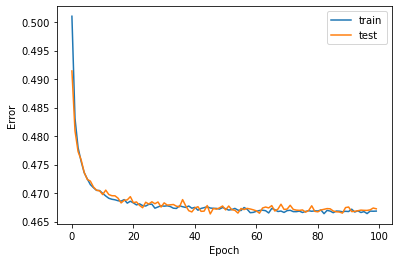

In [25]:
rbm100 = create_rbm(train_matrix, test_matrix, 1024, 2000, 100)
evaluate_rbm(rbm100)

start training


100%|██████████| 10/10 [02:41<00:00, 16.14s/it]


Vanilla RBM


100%|██████████| 31/31 [00:10<00:00,  3.05it/s]

hr 0.20920391430838403
recall 0.022893821333387583
ndcg 0.025929959458251908


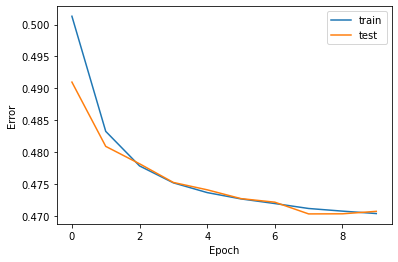

In [25]:
rbm10 = create_rbm(train_matrix, test_matrix, 1024, 2000, 10)
evaluate_rbm(rbm10)

In [26]:
torch.save(rbm100.state_dict(), "./network-steam100-train0")

In [ ]:
def recommend(rbm, v, vt, k, p=True):
    target_data = vt.data
    target_index = vt.indices
    target_recommendations = target_index[target_data == 1]
    v = v.todense()
    # v = v - 1
    v = torch.Tensor(v)
    if torch.cuda.is_available():
        v = v.cuda()
    
    _, h = rbm.sample_h(v)
    recommended, _ = rbm.sample_v(h)

    # all recommendations
    values, indices =  torch.topk(recommended[v < 1], k)
    recommendations = indices.cpu().tolist()

    if p:
        # print('20', recommended[0][20])
        # print('21', recommended[0][21])
        print("average value", torch.mean(recommended[0]))

    found = True
    for r in recommendations:
        if r in target_recommendations:
            if p:
                print("HIT")
            found = True
            break

    if found and p:
        print("values", values)
        print("recommended", recommendations)
        print("real", target_recommendations)
        print("len real", len(target_recommendations))

    
    
    return recommendations

user = 100
# print("train", train_matrix[user])
# print("test", test_matrix[user])


In [ ]:

print("EPOCHS 10")
recommend(rbm10, train_matrix[user], test_matrix[user], 10)
print('---' * 10)
print("EPOCHS 100")
recommend(rbm100, train_matrix[user], test_matrix[user], 10)

In [33]:
import gc

gc.collect()

torch.cuda.empty_cache()

start training


100%|██████████| 2000/2000 [2:13:47<00:00,  4.01s/it]


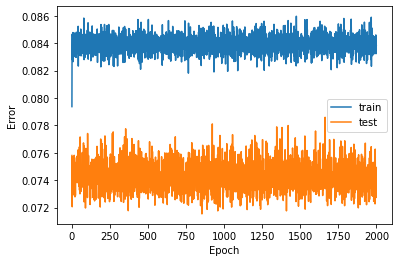

In [ ]:
rbm2000 = create_rbm(train_matrix, test_matrix, 100, 10000, 2000)

In [ ]:

recommend(rbm2000, train_matrix[user], test_matrix[user], 10)

average value tensor(0.0020, device='cuda:0')
values tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9857, 0.7724, 0.7508, 0.7067, 0.6375,
        0.6081], device='cuda:0')
recommended [63, 1350, 204, 186, 271, 1277, 1906, 43, 1884, 19]
real [  58  101  157  171  178  221  229  318  532  576 1698]
len real 11


[63, 1350, 204, 186, 271, 1277, 1906, 43, 1884, 19]

In [ ]:
print("2000 epochs")
hr, r, ndcg = compute_hr(train_matrix, test_matrix, rbm2000)
print("hr", np.average(hr))
print("recall", np.average(r))
print("ndcg", np.average(ndcg))

2000 epochs
hr 0.26885435533705726
recall 0.036593026174615496
ndcg 0.03986529999302447


In [ ]:
# hrs = []
# rs = []
# for i in range(10):
#     rbm = create_rbm(user_reviews_df_exploded['item_id_int'].max() + 1, 1024, 10240, i)
#     hr, r = compute_hr(rbm)
#     hrs.append(np.average(hr))
#     rs.append(np.average(r))

In [ ]:
# plt.clf()
# plt.plot(hrs, label='HR')
# plt.plot(rs, label='Recall')
# plt.xlabel("Epochs")
# plt.legend()

In [ ]:
rbm1 = create_rbm(user_reviews_df_exploded['item_id_int'].max() + 1, 1024, 10240, 50)
hr, r, ndcg = compute_hr(rbm1)
print("hr", np.average(hr))
print("recall", np.average(r))
print("ndcg", np.average(r))

start training


100%|██████████| 50/50 [00:46<00:00,  1.06it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_22208/2552676182.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


ValueError: too many values to unpack (expected 2)

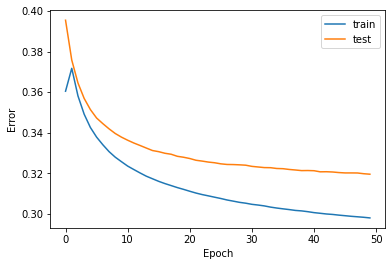

In [ ]:
rbm50 = create_rbm(user_reviews_df_exploded['item_id_int'].max() + 1, 1024, 10240, 50)
hr, r = compute_hr(rbm50)
print("hr", np.average(hr))
print("recall", np.average(r))

In [ ]:
print("EPOCHS 50")
recommend(rbm50, train_matrix[user], test_matrix[user], 10)

EPOCHS 50
20 tensor(0.9153, device='cuda:0')
21 tensor(0.9358, device='cuda:0')
tensor(0.6323, device='cuda:0')
values tensor([0.9930, 0.9917, 0.9917, 0.9910, 0.9908, 0.9906, 0.9888, 0.9876, 0.9863,
        0.9855], device='cuda:0')
recommended [0, 139, 36, 331, 93, 62, 54, 110, 34, 195]
real [20 21]


C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/3369171806.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


True

start training


100%|██████████| 100/100 [01:31<00:00,  1.10it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_3944/1456703759.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


hr 0.0282801310838694
recall 0.021958571023991583
ndcg 0.012341552449629993


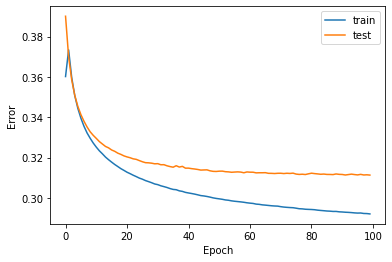

In [ ]:
rbm100 = create_rbm(user_reviews_df_exploded['item_id_int'].max() + 1, 1024, 10240, 100)
hr, r, ndcg = compute_hr(rbm100)
print("hr", np.average(hr))
print("recall", np.average(r))
print("ndcg", np.average(ndcg))

In [ ]:
all_recommendations = set()
for u in range(train_matrix.shape[0]):
    recommendations = recommend(rbm50, train_matrix[u], test_matrix[u], 10, False)
    all_recommendations.update(recommendations)

print(len(all_recommendations))

C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/4121192494.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


95


In [ ]:
all_recommendations = set()
for u in range(train_matrix.shape[0]):
    recommendations = recommend(rbm20, train_matrix[u], test_matrix[u], 10, False)
    all_recommendations.update(recommendations)

print(len(all_recommendations))

C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/4121192494.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


88


In [ ]:
all_recommendations = set()
for u in range(train_matrix.shape[0]):
    recommendations = recommend(rbm10, train_matrix[u], test_matrix[u], 10, False)
    all_recommendations.update(recommendations)

print(len(all_recommendations))

C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/4121192494.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


77


In [ ]:
print(train_matrix.shape[1])

3682


start training


100%|██████████| 500/500 [07:14<00:00,  1.15it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/1445240602.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


hr 0.043295398317664525
recall 0.034960003298697015


C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/4121192494.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


113


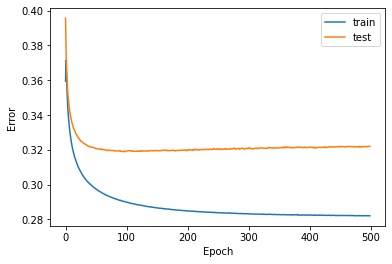

In [ ]:
rbm500 = create_rbm(user_reviews_df_exploded['item_id_int'].max() + 1, 1024, 10240, 500)
hr, r = compute_hr(rbm50)
print("hr", np.average(hr))
print("recall", np.average(r))

all_recommendations = set()
for u in range(train_matrix.shape[0]):
    recommendations = recommend(rbm500, train_matrix[u], test_matrix[u], 10, False)
    all_recommendations.update(recommendations)

print(len(all_recommendations))

In [ ]:
hr, r = compute_hr(rbm500)
print("hr", np.average(hr))
print("recall", np.average(r))

C:\Users\jolan\AppData\Local\Temp/ipykernel_4044/1445240602.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


hr 0.02016328550222662
recall 0.015879102754412004


start training


100%|██████████| 2000/2000 [28:52<00:00,  1.15it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_3944/1456703759.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


hr 0.02730913945867217
recall 0.02056277056277056
ndcg 0.009893964932566628


NameError: name 'recommend' is not defined

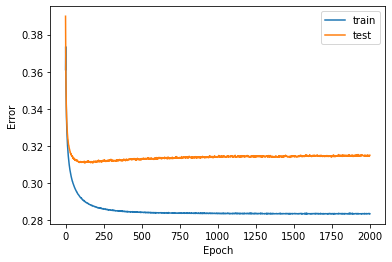

In [ ]:
rbm2000 = create_rbm(user_reviews_df_exploded['item_id_int'].max() + 1, 1024, 10240, 2000)
hr, r, ndcg = compute_hr(rbm2000)
print("hr", np.average(hr))
print("recall", np.average(r))
print("ndcg", np.average(ndcg))

all_recommendations = set()
for u in range(train_matrix.shape[0]):
    recommendations = recommend(rbm2000, train_matrix[u], test_matrix[u], 10, u == train_matrix.shape[0] - 1)
    all_recommendations.update(recommendations)

print(len(all_recommendations))

## Hyperparam searching

start training


100%|██████████| 100/100 [01:09<00:00,  1.43it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_3944/2706428938.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


start training


100%|██████████| 100/100 [01:39<00:00,  1.01it/s]
C:\Users\jolan\AppData\Local\Temp/ipykernel_3944/2706428938.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


start training


100%|██████████| 100/100 [03:46<00:00,  2.26s/it]
C:\Users\jolan\AppData\Local\Temp/ipykernel_3944/2706428938.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


start training


100%|██████████| 100/100 [06:29<00:00,  3.89s/it]
C:\Users\jolan\AppData\Local\Temp/ipykernel_3944/2706428938.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


{'100-[100, 1000, 5000, 10000]': ([1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
  

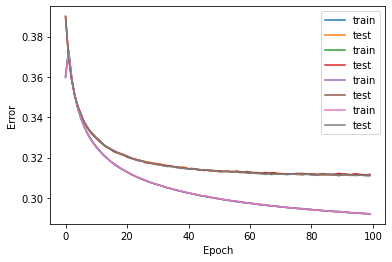

In [ ]:
epochs = [100]
hidden = [100, 1000, 5000, 10000]
rbms = []
results = {}

for epoch in epochs:
    for n_hidden in hidden:
        rbm = create_rbm(train_matrix, test_matrix, n_hidden, 10240, epoch)
        rbms.append(rbm)
        hr, r, ndcg = compute_hr(train_matrix, test_matrix, rbm)
        results[f"{epoch}-{n_hidden}"] = (np.average(hr), np.average(r), np.average(ndcg))

results

In [ ]:
for i, rbm in enumerate(rbms):
    hr, r, ndcg = compute_hr(train_matrix, test_matrix, rbm)
    results[f"{100}-{hidden[i]}"] = (np.average(hr), np.average(r), np.average(ndcg))
    
results

C:\Users\jolan\AppData\Local\Temp/ipykernel_3944/2706428938.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recommendations = torch.tensor(indices, device='cpu').tolist()


{'100-[100, 1000, 5000, 10000]': (0.038232795242141036,
  0.029048832787150546,
  0.015129883968285325),
 '100-100': (0.03859691710159, 0.029321924181737263, 0.01330594743959745),
 '100-1000': (0.03422745478820245, 0.026054941942792405, 0.012561496199119393),
 '100-5000': (0.03799004733584173, 0.02899826030667152, 0.013694640578542241),
 '100-10000': (0.038232795242141036,
  0.029048832787150546,
  0.015129883968285325)}

In [ ]:
import pprint
pprint.pprint(results)

{'100-100': (0.03859691710159, 0.029321924181737263, 0.01330594743959745),
 '100-1000': (0.03422745478820245, 0.026054941942792405, 0.012561496199119393),
 '100-10000': (0.038232795242141036,
               0.029048832787150546,
               0.015129883968285325),
 '100-5000': (0.03799004733584173, 0.02899826030667152, 0.013694640578542241),
 '100-[100, 1000, 5000, 10000]': (0.038232795242141036,
                                  0.029048832787150546,
                                  0.015129883968285325)}


In [ ]:
# torch.save(rbm.state_dict(), "./network")

In [ ]:
# rbm = RBM(n_vis, n_hidden)
# rbm.load_state_dict(torch.load("./network"))
# rbm.eval()